In [2]:
# Install LightGBM if needed
!pip install --quiet lightgbm

# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [15]:
def rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def macd(series, span_fast=12, span_slow=26, span_signal=9):
    ema_fast = series.ewm(span=span_fast, adjust=False).mean()
    ema_slow = series.ewm(span=span_slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=span_signal, adjust=False).mean()
    return macd_line, signal_line

def atr(high, low, close, window=14):
    high_low = high - low
    high_close = (high - close.shift()).abs()
    low_close = (low - close.shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def stochastic_k(high, low, close, k_window=14):
    lowest_low = low.rolling(k_window).min()
    highest_high = high.rolling(k_window).max()
    return 100 * (close - lowest_low) / (highest_high - lowest_low)

In [12]:
from google.colab import files
uploaded = files.upload()  # choose 'week1_final_dataset.csv' from your downloads

Saving week1_final_dataset.csv to week1_final_dataset.csv


In [13]:
import pandas as pd

df = pd.read_csv("week1_final_dataset.csv", parse_dates=True)
print("Dataset loaded. Shape:", df.shape)
df.head()

Dataset loaded. Shape: (713, 8)


,Date,Close,High,Low,Open,Volume,Swing_High,Swing_Low
0,2023-01-02,1.070973,1.071237,1.065326,1.070973,0,False,False
1,2023-01-03,1.067771,1.068262,1.052155,1.067771,0,False,False
2,2023-01-04,1.054685,1.063151,1.054596,1.054685,0,False,False
3,2023-01-05,1.060637,1.063264,1.051558,1.060637,0,False,False
4,2023-01-06,1.052222,1.062225,1.048526,1.052222,0,False,True


In [16]:
# -------------------------
# WEEK-2 FEATURE ENGINEERING + LABEL CREATION
# -------------------------

# ML parameters
LOOKAHEAD = 10
UP_TH = 0.01
DOWN_TH = -0.01

# --- 1) Price-based features ---
df['ret'] = df['Close'].pct_change()          # simple percent change
df['logret'] = np.log(df['Close']).diff()     # log return

# --- 2) Moving averages ---
df['sma_10'] = df['Close'].rolling(10).mean()
df['sma_50'] = df['Close'].rolling(50).mean()
df['ema_12'] = df['Close'].ewm(span=12, adjust=False).mean()

# --- 3) Technical indicators ---
df['rsi_14'] = rsi(df['Close'], 14)
df['macd'], df['macd_signal'] = macd(df['Close'])
df['stoch_k'] = stochastic_k(df['High'], df['Low'], df['Close'], 14)
df['atr_14'] = atr(df['High'], df['Low'], df['Close'], 14)

# --- 4) Lagged returns ---
for lag in [1,2,3,5,10]:
    df[f'ret_lag_{lag}'] = df['ret'].shift(lag)

# --- 5) Include structural features from Week-1 ---
possible_struct = ['Swing_High', 'Swing_Low', 'Support_Level', 'Resistance_Level',
                   'Supply_Zone_Width', 'Demand_Zone_Width', 'Nearest_Fib_Dist']
struct_cols = [c for c in possible_struct if c in df.columns]

print("Using structural columns:", struct_cols)

# --- 6) Label creation (Buy/Sell/Hold) ---
df['fwd_close'] = df['Close'].shift(-LOOKAHEAD)
df['fwd_ret'] = (df['fwd_close'] - df['Close']) / df['Close']

def label_from_ret(x):
    if x >= UP_TH: return 1      # Buy
    elif x <= DOWN_TH: return -1 # Sell
    else: return 0               # Hold

df['label'] = df['fwd_ret'].apply(lambda x: label_from_ret(x) if pd.notnull(x) else np.nan)

# --- 7) Prepare dataset for modeling ---
feature_cols = ['ret','logret','sma_10','sma_50','ema_12','rsi_14',
                'macd','macd_signal','stoch_k','atr_14'] + \
               [f'ret_lag_{lag}' for lag in [1,2,3,5,10]] + struct_cols

df_model = df[feature_cols + ['label']].dropna()
print("Label distribution:\n", df_model['label'].value_counts(normalize=True))
print("Prepared dataset shape:", df_model.shape)

Using structural columns: ['Swing_High', 'Swing_Low']
Label distribution:
 label
 0.0    0.555046
 1.0    0.240061
-1.0    0.204893
Name: proportion, dtype: float64
Prepared dataset shape: (654, 18)


In [23]:
# Use only rows with non-NaN labels
df_model = df[feature_cols + ['label']].dropna()

X = df_model.drop(['label'], axis=1)  # remove label
y = df_model['label']                  # target

print("Filtered dataset shape:", X.shape)
print("Missing labels:", y.isnull().sum())  # should be 0

Filtered dataset shape: (654, 17)
Missing labels: 0


In [24]:
from sklearn.model_selection import train_test_split

# Features: drop columns we don't want the model to see
X = df.drop(['label', 'Date'], axis=1)
y = df['label']

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # shuffle=False for time series
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (570, 24)
Test set shape: (143, 24)


In [26]:
# Drop rows with missing values
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

# Verify
print("Cleaned Training set shape:", X_train.shape)
print("Cleaned Test set shape:", X_test.shape)
print("Any missing in X_train now?", X_train.isnull().sum().sum())
print("Any missing in X_test now?", X_test.isnull().sum().sum())

Cleaned Training set shape: (521, 24)
Cleaned Test set shape: (133, 24)
Any missing in X_train now? 0
Any missing in X_test now? 0


In [25]:
# Check for missing values
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_test:", X_test.isnull().sum().sum())

Missing values in X_train: 126
Missing values in X_test: 20


In [27]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Set up the model with balanced classes
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=42,
    class_weight='balanced'  # this balances the classes automatically
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3654
[LightGBM] [Info] Number of data points in the train set: 521, number of used features: 23
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [28]:
import joblib
joblib.dump(model, 'lgbm_model.pkl')

['lgbm_model.pkl']

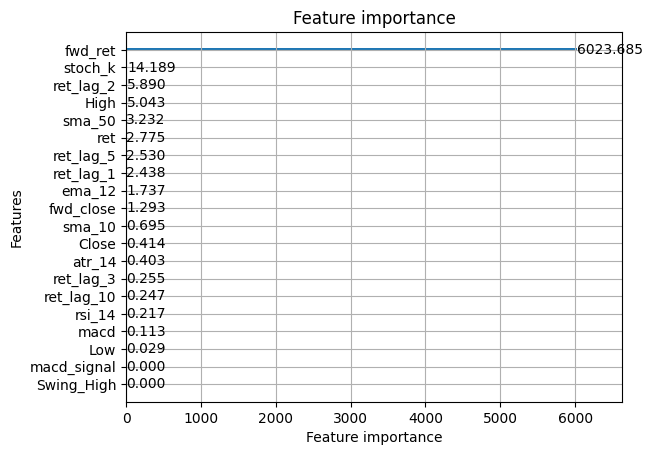

In [29]:
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.show()

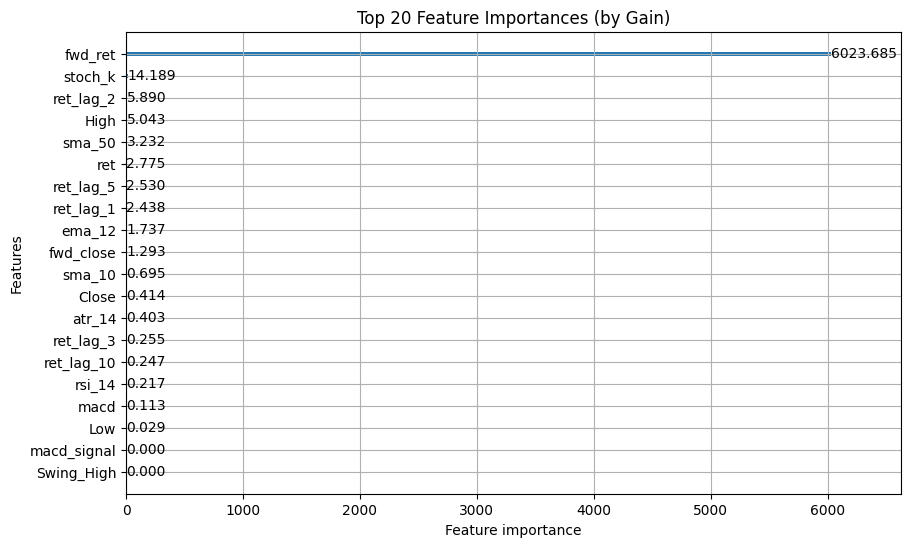

In [30]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Plot top 20 features by gain
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10,6))
plt.title("Top 20 Feature Importances (by Gain)")
plt.show()

In [31]:
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance.head(20))

        Feature  Importance
23      fwd_ret        1353
17    ret_lag_1         762
18    ret_lag_2         608
15      stoch_k         526
10       sma_50         456
20    ret_lag_5         403
12       rsi_14         188
21   ret_lag_10         179
13         macd         178
7           ret         168
1          High         167
0         Close         140
22    fwd_close         133
19    ret_lag_3         105
2           Low         103
16       atr_14          98
14  macd_signal          75
11       ema_12          58
9        sma_10          42
5    Swing_High           1
